# NLP - DNN 통합코드 (강희숙 강사님)

In [2]:
# 통합코드

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# 데이터 로드
df = pd.read_csv('[Dataset]_Module25_disasters_social_media.csv')

df_choose = df[df['choose_one'] != "Can't Decide"].copy()

# 'text' 컬럼 전처리
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자와 숫자 제거
    text = re.sub(r'[^a-z\s]', '', text)
    # 불필요한 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    # 표제어 추출 및 불용어 제거
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df_choose['text'] = df_choose['text'].apply(preprocess_text)

# 레이블 인코딩
label_encoder = LabelEncoder()
df_choose['choose_one'] = label_encoder.fit_transform(df_choose['choose_one'])

# 학습 및 테스트 데이터 분리
X = df_choose['text'].values
Y = df_choose['choose_one'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 토큰화 및 시퀀스 패딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

=== 문장 길이 분석 ===
평균 길이: 9.67
중간값: 10.0
최소 길이: 0
최대 길이: 22
95% 백분위: 15
99% 백분위: 17


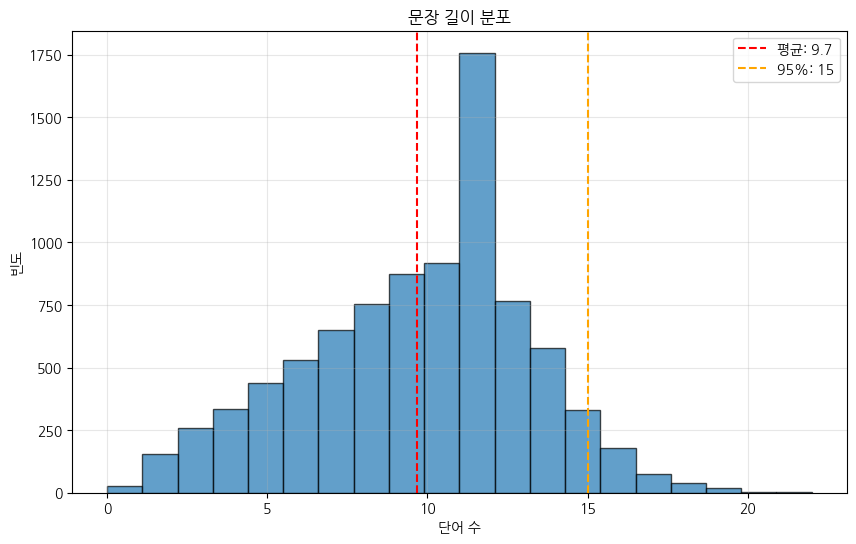


=== max_len 옵션 ===
옵션 1 (최댓값): 22 - 모든 문장 보존, 메모리 많이 사용
옵션 2 (95%): 15 - 5% 문장 잘림, 메모리 효율적
옵션 3 (99%): 17 - 1% 문장 잘림, 균형

선택된 max_len: 15
최종 shape - X_train: (8688, 15), X_test: (2172, 15)


In [4]:
import koreanize_matplotlib

print("=== 문장 길이 분석 ===")
lengths = [len(seq) for seq in X_train_sequences]

print(f"평균 길이: {np.mean(lengths):.2f}")
print(f"중간값: {np.median(lengths):.1f}")
print(f"최소 길이: {min(lengths)}")
print(f"최대 길이: {max(lengths)}")
print(f"95% 백분위: {np.percentile(lengths, 95):.0f}")
print(f"99% 백분위: {np.percentile(lengths, 99):.0f}")

# 길이 분포 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=20, alpha=0.7, edgecolor='black')
plt.title('문장 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.axvline(np.mean(lengths), color='red', linestyle='--', label=f'평균: {np.mean(lengths):.1f}')
plt.axvline(np.percentile(lengths, 95), color='orange', linestyle='--', label=f'95%: {np.percentile(lengths, 95):.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# max_len 결정
print("\n=== max_len 옵션 ===")
option1 = max(lengths)  # 현재 방식
option2 = int(np.percentile(lengths, 95))  # 95% 커버
option3 = int(np.percentile(lengths, 99))  # 99% 커버

print(f"옵션 1 (최댓값): {option1} - 모든 문장 보존, 메모리 많이 사용")
print(f"옵션 2 (95%): {option2} - 5% 문장 잘림, 메모리 효율적")
print(f"옵션 3 (99%): {option3} - 1% 문장 잘림, 균형")

# 선택한 max_len 적용
max_len = option2  # 또는 option1, option3 중 선택

print(f"\n선택된 max_len: {max_len}")


# 패딩 적용

X_train = pad_sequences(X_train_sequences, maxlen=max_len)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

print(f"최종 shape - X_train: {X_train.shape}, X_test: {X_test.shape}")

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Dense, Flatten, GlobalAveragePooling1D

# DNN 모델 구성 ( Flatten 사용)

model_dnn = Sequential()
model_dnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
model_dnn.add(Dropout(0.2))
model_dnn.add(Flatten())  # 3D tensor를 2D로 변환   # 순서 정보 무시, 모든 위치를 동등하게 처리
model_dnn.add(Dense(512, activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(128, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(1, activation='sigmoid'))

model_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_dnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6478 - loss: 0.6238 - val_accuracy: 0.7841 - val_loss: 0.4721
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9072 - loss: 0.2442 - val_accuracy: 0.7657 - val_loss: 0.5816
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9788 - loss: 0.0636 - val_accuracy: 0.7615 - val_loss: 0.7856
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9898 - loss: 0.0245 - val_accuracy: 0.7634 - val_loss: 0.9891
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9943 - loss: 0.0140 - val_accuracy: 0.7509 - val_loss: 1.0980
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9965 - loss: 0.0093 - val_accuracy: 0.7491 - val_loss: 1.2417
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9954 - loss: 0.0094 - val_accuracy: 0.7555 - val_loss: 1.1461
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9957 - loss: 0.0087 - val_accu

In [6]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# 이진분류 예측 및 평가
y_pred = model_dnn.predict(X_test)

# y_pred와 y_test의 shape 확인
print(f"y_pred shape: {y_pred.shape}")
print(f"y_test shape: {y_test.shape}")

# y_pred 처리 (sigmoid 출력이므로 0.5 threshold 사용)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# y_test는 이미 binary 형태이므로 그대로 사용
y_test_classes = y_test  # 이미 [0, 1, 0, 1, ...] 형태

# shape 확인
print(f"y_pred_classes shape: {y_pred_classes.shape}")
print(f"y_test_classes shape: {y_test_classes.shape}")

# 평가
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes, target_names=['not relevant', 'relevant'])

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
y_pred shape: (2172, 1)
y_test shape: (2172,)
y_pred_classes shape: (2172,)
y_test_classes shape: (2172,)
Accuracy: 0.7500
Classification Report:
               precision    recall  f1-score   support

not relevant       0.75      0.83      0.79      1203
    relevant       0.75      0.65      0.70       969

    accuracy                           0.75      2172
   macro avg       0.75      0.74      0.74      2172
weighted avg       0.75      0.75      0.75      2172



In [7]:
# 임의의 문장 3개
sentences = ["Emergency situation at the airport",
             "What a beautiful day!",
             "Help needed due to flooding in the area"]

# 전처리
preprocessed_sentences = [preprocess_text(sentence) for sentence in sentences]
sequences = tokenizer.texts_to_sequences(preprocessed_sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# 예측
predictions = model_dnn.predict(padded_sequences)

# 클래스 이름 정의 (df_choose['choose_one'].value_counts() 결과에 맞춤)
class_names = ['not relevant', 'relevant']  # 0: not relevant, 1: relevant

for i, prediction in enumerate(predictions):
    # sigmoid 출력 (0~1 사이 확률값)
    prob = prediction[0]  # 확률값 추출
    predicted_class_idx = int(prob > 0.5)  # 0.5 threshold로 클래스 결정
    confidence = prob if predicted_class_idx == 1 else 1 - prob  # 예측된 클래스의 확신도
    
    predicted_class = class_names[predicted_class_idx]
    
    print(f"Input: {sentences[i]}")
    print(f"Predicted class: {predicted_class} (Confidence: {confidence:.2f})")
    print(f"Raw probability: {prob:.4f}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Input: Emergency situation at the airport
Predicted class: relevant (Confidence: 0.99)
Raw probability: 0.9915

Input: What a beautiful day!
Predicted class: not relevant (Confidence: 1.00)
Raw probability: 0.0001

Input: Help needed due to flooding in the area
Predicted class: relevant (Confidence: 1.00)
Raw probability: 1.0000

